Using TensorFlow backend.


(50000, 28, 28) (50000,)


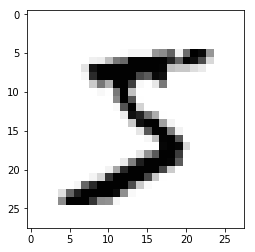

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import keras

# Create one-hot categories
y_train_one_hot = keras.utils.to_categorical(y_train)
y_val_one_hot = keras.utils.to_categorical(y_val)
y_test_one_hot = keras.utils.to_categorical(y_test)

print(X_train.shape, y_train_one_hot.shape)
print(X_val.shape, y_val_one_hot.shape)
print(X_test.shape, y_test_one_hot.shape)

(50000, 28, 28) (50000, 10)
(10000, 28, 28) (10000, 10)
(10000, 28, 28) (10000, 10)


In [3]:
import numpy as np
import tensorflow as tf


def batch_iter(x, y, batch_size=64):
    data_len = len(x)
    num_batch = 1 + int((data_len-1)/batch_size)
    for i in range(num_batch):
        a = i*batch_size
        b = min(data_len, a+batch_size)
        yield x[a:b], y[a:b]


In [4]:
# define MLP
input_x = tf.placeholder(name='input_x',
                        dtype=tf.float32,
                        shape=[None, 28, 28])
input_y = tf.placeholder(name='input_y',
                        dtype=tf.float32,
                        shape=[None, 10])

flatten_input_x = tf.reshape(input_x,
                            shape=[-1, 28*28])

fc1 = tf.layers.dense(flatten_input_x, 700)
fc1 = tf.nn.dropout(fc1, .5)
fc1 = tf.nn.relu(fc1)

fc2 = tf.layers.dense(fc1, 500)
fc2 = tf.nn.dropout(fc2, .5)
fc2 = tf.nn.relu(fc2)

# fc3 = tf.layers.dense(fc2, 500)
# fc3 = tf.nn.dropout(fc3, .5)
# fc3 = tf.nn.relu(fc3)

fc4 = tf.layers.dense(fc2, 250)
fc4 = tf.nn.dropout(fc4, .5)
fc4 = tf.nn.relu(fc4)

logits = tf.layers.dense(fc4, 10)
softmax = tf.nn.softmax(logits)
predicted_y = tf.argmax(softmax, 1)
correct_pred = tf.equal(tf.argmax(input_y, 1), tf.cast(predicted_y, tf.int64))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits)


loss = tf.reduce_mean(cross_entropy)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
saver = tf.train.Saver()

In [5]:
from sklearn.metrics import roc_auc_score

train_losses = []
val_losses = []
ckpt_path = './MLP-MNIST'
def train():
    total_iter = 0
    last_improve_epoch = 0
    best_val_acc = 0.0
    for epoch in range(50):
        print('epoch: {}'.format(epoch+1))
        batchs = batch_iter(X_train, y_train_one_hot)
        for x_batch, y_batch in batchs:
            sess.run(optim, {input_x: x_batch, input_y: y_batch})
            total_iter += 1
        loss_train, acc_train = sess.run([loss, accuracy], {input_x:X_train, input_y:y_train_one_hot})
        train_losses.append(loss_train)
        loss_val, acc_val = sess.run([loss, accuracy], {input_x:X_val, input_y:y_val_one_hot})
        val_losses.append(loss_val)
        print("loss on val at epoch %i is: %.4f" % (epoch, loss_val))
        print("accuracy on val at epoch %i is: %.4f" % (epoch, acc_val))
        if acc_val > best_val_acc:
            last_improve_epoch = epoch
            best_val_acc = acc_val
            saver.save(sess, ckpt_path)
        elif epoch - last_improve_epoch > 10:
            break
        print('*'*50)


In [6]:
def test():
    saver.restore(sess, ckpt_path)
    loss_test = sess.run(loss, {input_x: X_test, input_y: y_test_one_hot})
    print("loss on test: %.4f" % (loss_test))
    acc_test = sess.run(accuracy, {input_x: X_test, input_y: y_test_one_hot})
    print("accuracy on test: %.4f" % (acc_test))
#     print("test auc:", roc_auc_score(y_test_one_hot, sess.run(logits, {input_x:X_test})))

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
print('\n\ntraining')
train()
print('\n\ntesting')
test()
sess.close()



training
epoch: 1
loss on val at epoch 0 is: 0.2151
accuracy on val at epoch 0 is: 0.9369
**************************************************
epoch: 2
loss on val at epoch 1 is: 0.1747
accuracy on val at epoch 1 is: 0.9529
**************************************************
epoch: 3
loss on val at epoch 2 is: 0.1597
accuracy on val at epoch 2 is: 0.9579
**************************************************
epoch: 4
loss on val at epoch 3 is: 0.1590
accuracy on val at epoch 3 is: 0.9582
**************************************************
epoch: 5
loss on val at epoch 4 is: 0.1442
accuracy on val at epoch 4 is: 0.9633
**************************************************
epoch: 6
loss on val at epoch 5 is: 0.1484
accuracy on val at epoch 5 is: 0.9622
**************************************************
epoch: 7
loss on val at epoch 6 is: 0.1560
accuracy on val at epoch 6 is: 0.9620
**************************************************
epoch: 8
loss on val at epoch 7 is: 0.1447
accuracy on val at epo

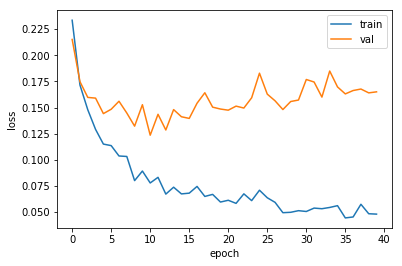

In [8]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show()